In [12]:
# Visualize the classification results
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, average_precision_score,confusion_matrix
from model.utils import create_hetero_data,get_parser
from model.models import HeteroGNN_SMOTE
from torch.nn import functional as F


In [4]:
def calculate_metrics(y_true, y_pred, y_prob=None):
    """
    Calculate various metrics for multi-class classification.

    Parameters:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.
    y_prob (array-like, optional): Predicted probabilities for each class.

    Returns:
    dict: A dictionary containing the calculated metrics.
    """
    metrics = {}
    
    # Macro and Micro F1 scores
    metrics['macro_f1'] = f1_score(y_true, y_pred, average='macro')
    metrics['micro_f1'] = f1_score(y_true, y_pred, average='micro')
    
    # Precision and Recall
    metrics['precision'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['recall'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    
    if y_prob is not None:
        # AUC and Precision-Recall AUC
        metrics['auc'] = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
        metrics['pr_auc'] = average_precision_score(y_true, y_prob, average='macro')
    
    return metrics

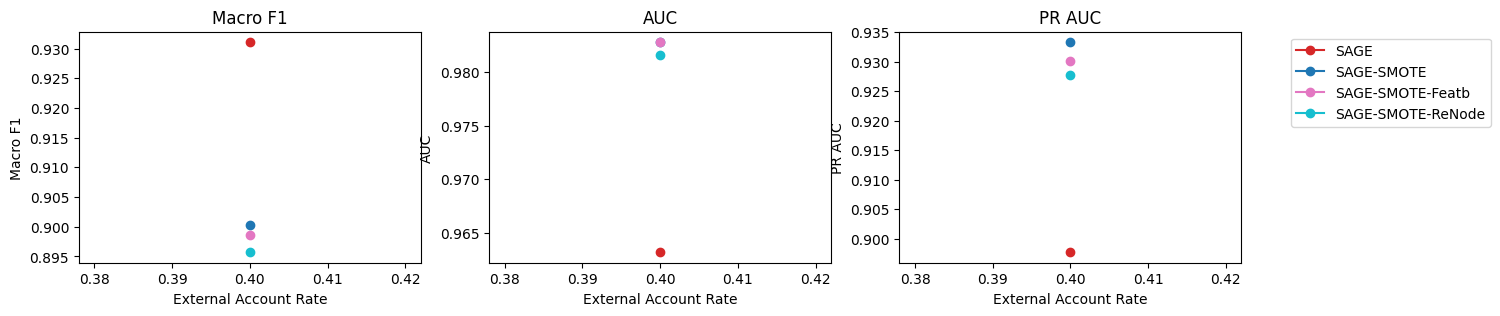

In [16]:
from sklearn.metrics import roc_curve, precision_recall_curve

# Load the data
data_name = "elliptic"
ext_rates = np.array([0.4])
origin_results = {}
smote_results = {}
featb_results = {}
topob_results = {}
knn_results = {}
for ext_rate in ext_rates:
    ext_rate = round(ext_rate, 1)
    origin_results[ext_rate] = np.load(f"outputs/{data_name}/baseline_hetero_SAGE_ext_{ext_rate}.npz")
    smote_results[ext_rate] = np.load(f"outputs/{data_name}/baseline_hetero_SAGE-SMOTE_ext_{ext_rate}.npz")
    featb_results[ext_rate] = np.load(f"outputs/{data_name}/baseline_hetero_SAGE-SMOTE-Featb_ext_{ext_rate}.npz")
    topob_results[ext_rate] = np.load(f"outputs/{data_name}/hetero_SAGE-SMOTE-ReNode_ext_{ext_rate}.npz")
    knn_results[ext_rate] = np.load(f"outputs/{data_name}/baseline_KNN_ext_{ext_rate}.npz")
    
# Get the metrics for each experiment
smote_metrics = {}
origin_metrics = {}
featb_metrics = {}
topob_metrics = {}
knn_metrics = {}
for ext_rate in ext_rates:
    test_mask = smote_results[ext_rate]['test_mask']
    y_true = smote_results[ext_rate]['true'][test_mask]
    y_pred = smote_results[ext_rate]['pred_scores'].argmax(axis=1)[test_mask]
    y_prob = smote_results[ext_rate]['pred_scores'][:,1][test_mask]
    smote_metrics[ext_rate] = calculate_metrics(y_true, y_pred, y_prob)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    smote_metrics[ext_rate]['fpr'] = fpr
    smote_metrics[ext_rate]['tpr'] = tpr
    smote_metrics[ext_rate]['precision'] = precision
    smote_metrics[ext_rate]['recall'] = recall
    smote_metrics[ext_rate]['conf_matrix'] = confusion_matrix(y_true, y_pred)
    
    test_mask = origin_results[ext_rate]['test_mask']
    y_true = origin_results[ext_rate]['true'][test_mask]
    y_pred = origin_results[ext_rate]['pred_scores'].argmax(axis=1)[test_mask]
    y_prob = origin_results[ext_rate]['pred_scores'][:,1][test_mask]
    origin_metrics[ext_rate] = calculate_metrics(y_true, y_pred, y_prob)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    origin_metrics[ext_rate]['fpr'] = fpr
    origin_metrics[ext_rate]['tpr'] = tpr
    origin_metrics[ext_rate]['precision'] = precision
    origin_metrics[ext_rate]['recall'] = recall
    origin_metrics[ext_rate]['conf_matrix'] = confusion_matrix(y_true, y_pred)
    
    test_mask = featb_results[ext_rate]['test_mask']
    y_true = featb_results[ext_rate]['true'][test_mask]
    y_pred = featb_results[ext_rate]['pred_scores'].argmax(axis=1)[test_mask]
    y_prob = featb_results[ext_rate]['pred_scores'][:,1][test_mask]
    featb_metrics[ext_rate] = calculate_metrics(y_true, y_pred, y_prob)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    featb_metrics[ext_rate]['fpr'] = fpr
    featb_metrics[ext_rate]['tpr'] = tpr
    featb_metrics[ext_rate]['precision'] = precision
    featb_metrics[ext_rate]['recall'] = recall
    featb_metrics[ext_rate]['conf_matrix'] = confusion_matrix(y_true, y_pred)
    
    test_mask = topob_results[ext_rate]['test_mask']
    y_true = topob_results[ext_rate]['true'][test_mask]
    y_pred = topob_results[ext_rate]['pred_scores'].argmax(axis=1)[test_mask]
    y_prob = topob_results[ext_rate]['pred_scores'][:,1][test_mask]
    topob_metrics[ext_rate] = calculate_metrics(y_true, y_pred, y_prob)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    topob_metrics[ext_rate]['fpr'] = fpr
    topob_metrics[ext_rate]['tpr'] = tpr
    topob_metrics[ext_rate]['precision'] = precision
    topob_metrics[ext_rate]['recall'] = recall
    topob_metrics[ext_rate]['conf_matrix'] = confusion_matrix(y_true, y_pred)
    
    y_true = knn_results[ext_rate]['true']
    y_pred = knn_results[ext_rate]['pred'][test_mask]
    y_prob = knn_results[ext_rate]['pred_scores'][:,1][test_mask]
    knn_metrics[ext_rate] = calculate_metrics(y_true, y_pred, y_prob)
    knn_metrics[ext_rate]['conf_matrix'] = confusion_matrix(y_true, y_pred)
    
    
# Plot the metrics of Macro_f1, AUC, and PR_AUC with respect to the extension rate of three models
metrics = ['macro_f1', 'auc', 'pr_auc']
metric_names = ['Macro F1', 'AUC', 'PR AUC']
colors = ['r', 'g', 'b']
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
# Use more beautiful color
cmap = plt.get_cmap('tab10')
colors = cmap(np.linspace(0, 1, 4))
for i, metric in enumerate(metrics):
    
    ax[i].plot(ext_rates, [origin_metrics[ext_rate][metric] for ext_rate in ext_rates], label='SAGE', color=colors[1],marker='o')
    ax[i].plot(ext_rates, [smote_metrics[ext_rate][metric] for ext_rate in ext_rates], label='SAGE-SMOTE', color=colors[0],marker='o')
    ax[i].plot(ext_rates, [featb_metrics[ext_rate][metric] for ext_rate in ext_rates], label='SAGE-SMOTE-Featb', color=colors[2],marker='o')
    ax[i].plot(ext_rates, [topob_metrics[ext_rate][metric] for ext_rate in ext_rates], label='SAGE-SMOTE-ReNode', color=colors[3],marker='o')
    ax[i].set_xlabel('External Account Rate')
    ax[i].set_ylabel(metric_names[i])
    ax[i].set_title(metric_names[i])
    if i ==len(metrics)-1:
        ax[i].legend(bbox_to_anchor=(1.75, 1), loc='upper right')

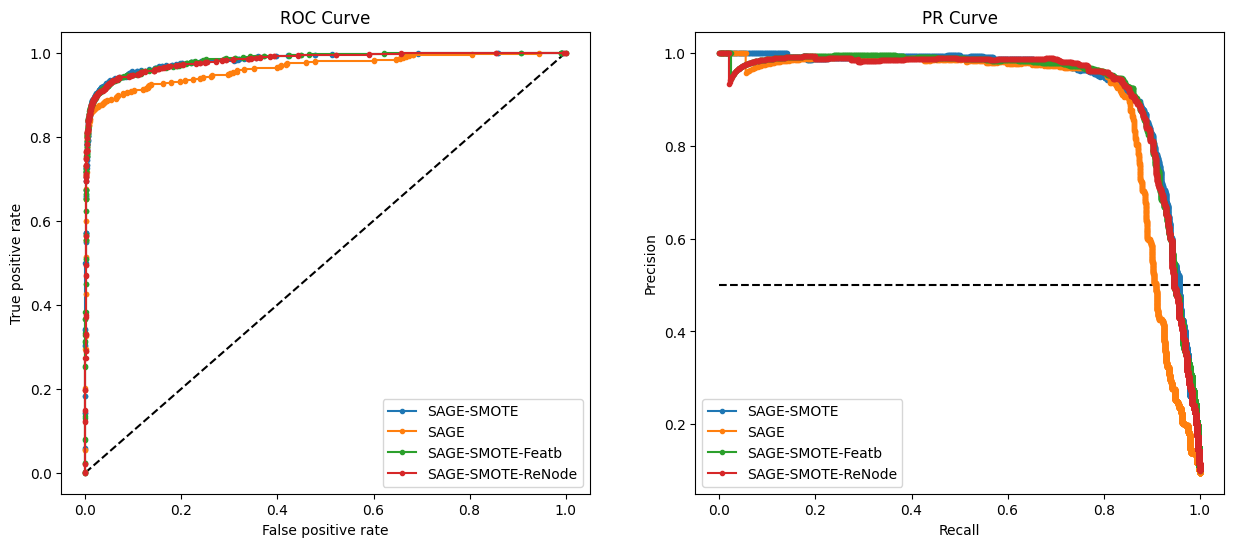

In [14]:
# Plot the ROC and PR-ROC curve of the four models in a specify external account rate
ext_rate = 0.4
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
# ROC curve
ms = 3
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(smote_metrics[ext_rate]['fpr'], smote_metrics[ext_rate]['tpr'], label='SAGE-SMOTE',marker='o',markersize=ms)
ax[0].plot(origin_metrics[ext_rate]['fpr'], origin_metrics[ext_rate]['tpr'], label='SAGE',marker='o',markersize=ms)
ax[0].plot(featb_metrics[ext_rate]['fpr'], featb_metrics[ext_rate]['tpr'], label='SAGE-SMOTE-Featb',marker='o',markersize=ms)
ax[0].plot(topob_metrics[ext_rate]['fpr'], topob_metrics[ext_rate]['tpr'], label='SAGE-SMOTE-ReNode',marker='o',markersize=ms)
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC Curve')
ax[0].legend()

# PR-ROC curve
ax[1].plot([0, 1], [0.5, 0.5], 'k--')
ax[1].plot(smote_metrics[ext_rate]['recall'], smote_metrics[ext_rate]['precision'], label='SAGE-SMOTE',marker='o',markersize=ms)
ax[1].plot(origin_metrics[ext_rate]['recall'], origin_metrics[ext_rate]['precision'], label='SAGE',marker='o',markersize=ms)
ax[1].plot(featb_metrics[ext_rate]['recall'], featb_metrics[ext_rate]['precision'], label='SAGE-SMOTE-Featb',marker='o',markersize=ms)
ax[1].plot(topob_metrics[ext_rate]['recall'], topob_metrics[ext_rate]['precision'], label='SAGE-SMOTE-ReNode',marker='o',markersize=ms)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('PR Curve')
ax[1].legend()


Text(1068.0048309178744, 0.5, 'True Label')

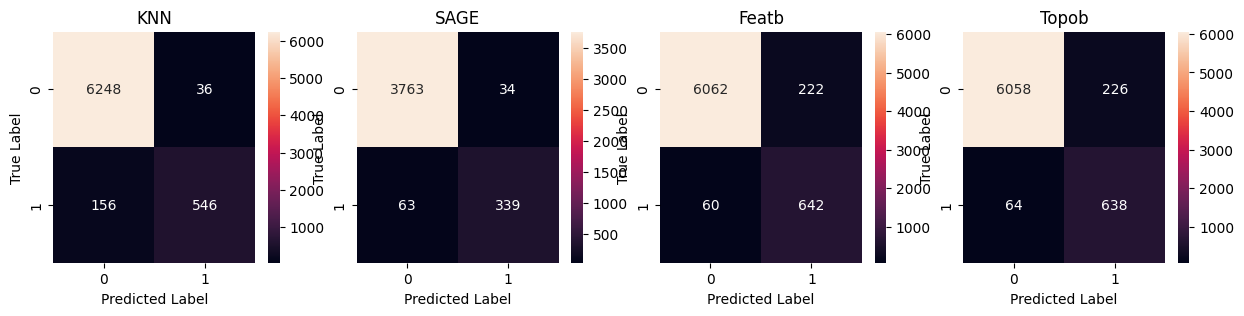

In [18]:
# Visualize the confusion matrix of four models
from sklearn.metrics import confusion_matrix
import seaborn as sns
ext_rate = 0.4
fig, ax = plt.subplots(1, 4, figsize=(15, 3))

sns.heatmap(knn_metrics[ext_rate]['conf_matrix'], annot=True, fmt='d', ax=ax[0])
ax[0].set_title('KNN')
ax[0].set_xlabel('Predicted Label')
ax[0].set_ylabel('True Label')

sns.heatmap(origin_metrics[ext_rate]['conf_matrix'], annot=True, fmt='d', ax=ax[1])
ax[1].set_title('SAGE')
ax[1].set_xlabel('Predicted Label')
ax[1].set_ylabel('True Label')

sns.heatmap(featb_metrics[ext_rate]['conf_matrix'], annot=True, fmt='d', ax=ax[2])
ax[2].set_title('Featb')
ax[2].set_xlabel('Predicted Label')
ax[2].set_ylabel('True Label')

sns.heatmap(topob_metrics[ext_rate]['conf_matrix'], annot=True, fmt='d', ax=ax[3])
ax[3].set_title('Topob')
ax[3].set_xlabel('Predicted Label')
ax[3].set_ylabel('True Label')
